## Домашняя работа по теме AOT классификация

### Задание: выполнить классификацию fakenews 3мя разными способами. Получить на задаче классификации значение f1 выше 0.91 для методов sklearn  и выше 0.52 для методов на pytorch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import nltk
from nltk.tokenize import word_tokenize

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from gensim.models.word2vec import Word2Vec
stops_en = stopwords.words("english")

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import wget
#wget.download('https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv', 'Constraint_Train.csv')

100% [..........................................................................] 1253562 / 1253562

'Constraint_Train (3).csv'

In [2]:
df = pd.read_csv('Constraint_Train.csv')

In [3]:
df.head(3)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake


In [4]:
df.tweet[2]

'Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville'

In [5]:
df.label.value_counts()

real    3360
fake    3060
Name: label, dtype: int64

Классы сбалансированы

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


типы данных в порядке, нулевые значения отсутствуют

#### Выполним токенизацию текста для последующей работы:

1. Не будем удалять знаки пунктуации, символы, стоп слова и выполнять лемматизацию, так как все эти нюансы нейровнная сеть может испольовать как основову для выявления паттернов. Приведем только слова в нижний регистр

In [7]:
tweets_asis = [word_tokenize(text.lower()) for text in tqdm(df.tweet)]

100%|████████████████████████████████████████████████████████████████████████████| 6420/6420 [00:02<00:00, 2795.74it/s]


In [9]:
tweets_asis[:2]

[['the',
  'cdc',
  'currently',
  'reports',
  '99031',
  'deaths',
  '.',
  'in',
  'general',
  'the',
  'discrepancies',
  'in',
  'death',
  'counts',
  'between',
  'different',
  'sources',
  'are',
  'small',
  'and',
  'explicable',
  '.',
  'the',
  'death',
  'toll',
  'stands',
  'at',
  'roughly',
  '100000',
  'people',
  'today',
  '.'],
 ['states',
  'reported',
  '1121',
  'deaths',
  'a',
  'small',
  'rise',
  'from',
  'last',
  'tuesday',
  '.',
  'southern',
  'states',
  'reported',
  '640',
  'of',
  'those',
  'deaths',
  '.',
  'https',
  ':',
  '//t.co/yasgrtt4ux']]

2. Лемматизируем твиты:

In [10]:
def review_to_wordlist(review, lemmatizer = None, remove_stopwords=False):
    # разбиваем обзор на слова
    words = word_tokenize(review.lower().strip())
    for word in words:
        if remove_stopwords:
            words = [w for w in words if not w in stops_en]
    lemmatized_word=[]
    if lemmatizer:
        for word in words:
            lemmatized_word.append(lemmatizer.lemmatize(word))
        return lemmatized_word
    return words

In [11]:
lemmatizer = WordNetLemmatizer()
#чтобы различать знаки пунктуации
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [12]:
tweets_lem_nosw = [review_to_wordlist(review, lemmatizer, remove_stopwords = True) for review in tqdm(df.tweet)]

100%|█████████████████████████████████████████████████████████████████████████████| 6420/6420 [00:23<00:00, 270.46it/s]


3. удалим стоп-слова и знаки пунктуации + лемматизация:

In [13]:
tweets_lem = [review_to_wordlist(review, lemmatizer, remove_stopwords = False) for review in tqdm(df.tweet)]

100%|████████████████████████████████████████████████████████████████████████████| 6420/6420 [00:03<00:00, 1836.04it/s]


Попробуем применить мешок слов для для выделения фич юни-би-грамм:

In [14]:
vectorizerCV1 = CountVectorizer(ngram_range=(1, 1))
vectorizerCV2 = CountVectorizer(ngram_range=(2, 2))
Xcv1_asis = vectorizerCV1.fit_transform([' '.join(tweet) for tweet in tweets_asis])
Xcv2_asis = vectorizerCV2.fit_transform([' '.join(tweet) for tweet in tweets_asis])
Xcv1_lem = vectorizerCV1.fit_transform([' '.join(tweet) for tweet in tweets_lem])
Xcv2_lem = vectorizerCV2.fit_transform([' '.join(tweet) for tweet in tweets_lem])
Xcv1_lem_nostops = vectorizerCV1.fit_transform([' '.join(tweet) for tweet in tweets_lem_nosw])
Xcv2_lem_nostops = vectorizerCV2.fit_transform([' '.join(tweet) for tweet in tweets_lem_nosw])

In [15]:
labels = (df.label == 'real').astype(int).to_list()
X_train_cv1_asis, X_test_cv1_asis, y_train_cv1_asis, y_test_cv1_asis = train_test_split(Xcv1_asis, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_cv2_asis, X_test_cv2_asis, y_train_cv2_asis, y_test_cv2_asis = train_test_split(Xcv2_asis, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_cv1_lem, X_test_cv1_lem, y_train_cv1_lem, y_test_cv1_lem = train_test_split(Xcv1_lem, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_cv2_lem, X_test_cv2_lem, y_train_cv2_lem, y_test_cv2_lem = train_test_split(Xcv2_lem, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_cv1_lem_nostops, X_test_cv1_lem_nostops, y_train_cv1_lem_nostops, y_test_cv1_lem_nostops = train_test_split(Xcv1_lem_nostops, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_cv2_lem_nostops, X_test_cv2_lem_nostops, y_train_cv2_lem_nostops, y_test_cv2_lem_nostops = train_test_split(Xcv2_lem_nostops, labels, test_size=0.2, random_state=42, stratify=labels)

Воспользуемся в качестве бэйзлайна догистической регрессией для классификации:

In [16]:
#просто токенизация с юни-граммами
model_asis = LogisticRegression(random_state = 42)
model_asis.fit(X_train_cv1_asis, y_train_cv1_asis)
predicted_asis = model_asis.predict(X_test_cv1_asis)
print(classification_report(y_test_cv1_asis, predicted_asis))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       612
           1       0.94      0.92      0.93       672

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284



In [17]:
#просто токенизации с биграммами
model_asis2 = LogisticRegression(random_state = 42)
model_asis2.fit(X_train_cv2_asis, y_train_cv2_asis)
predicted_asis2 = model_asis2.predict(X_test_cv2_asis)
print(classification_report(y_test_cv2_asis, predicted_asis2))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       612
           1       0.92      0.85      0.88       672

    accuracy                           0.88      1284
   macro avg       0.89      0.89      0.88      1284
weighted avg       0.89      0.88      0.88      1284



похоже биграммы показывают более худшй результат, поэтому далее будем применять юни-граммы

In [18]:
#лемматизированные твиты
model_lem = LogisticRegression(random_state = 42)
model_lem.fit(X_train_cv1_lem, y_train_cv1_lem)
predicted_lem = model_lem.predict(X_test_cv1_lem)
print(classification_report(y_test_cv1_lem, predicted_lem))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       612
           1       0.95      0.92      0.93       672

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284



In [19]:
#лемматизированные и без стопслов твиты
model_lem_nostops = LogisticRegression(random_state = 42)
model_lem_nostops.fit(X_train_cv1_lem_nostops, y_train_cv1_lem_nostops)
predicted_lem_nostops = model_lem_nostops.predict(X_test_cv1_lem_nostops)
print(classification_report(y_test_cv1_lem_nostops, predicted_lem_nostops))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       612
           1       0.95      0.92      0.94       672

    accuracy                           0.93      1284
   macro avg       0.93      0.94      0.93      1284
weighted avg       0.94      0.93      0.93      1284



Проверим покажут ли другие методы классификации лучший результат:

In [20]:
clf_lr = LogisticRegression()
clf_knn = KNeighborsClassifier()
clf_rf = RandomForestClassifier()
clf_ri = RidgeClassifier()
clf_svc = SVC()

In [23]:
params1 = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,30]}
params2 = {'n_neighbors': range(1,10)}
params3 = {'max_depth': range(2,20,3),
            'n_estimators': [5,10,15,20]}
params4 = {'alpha': [0.1, 0.2, 0.5, 1.0, 5., 10., 30.]}
params5 = {'C': [0.001,0.01,0.1,1,10, 50], 
          'gamma': [0.001, 0.01, 0.1, 1]}

In [24]:
best_estimators = []
for clf, params_dict in zip([clf_lr, clf_knn, clf_rf, clf_ri, clf_svc], [params1, params2, params3, params4, params5]):
    grid = GridSearchCV(clf, params_dict, cv=10, scoring='accuracy')
    grid.fit(X_train_cv1_asis, y_train_cv1_asis)
    print(clf.__class__.__name__, ':', grid.best_params_,"\t", 'acc:', grid.best_score_)

    best_estimators.append(grid.best_estimator_)

LogisticRegression : {'C': 10, 'penalty': 'l2'} 	 acc: 0.9330242489058792
KNeighborsClassifier : {'n_neighbors': 1} 	 acc: 0.7899230891755978
RandomForestClassifier : {'max_depth': 17, 'n_estimators': 20} 	 acc: 0.8742208417715279
RidgeClassifier : {'alpha': 10.0} 	 acc: 0.9308837918401711
SVC : {'C': 50, 'gamma': 0.01} 	 acc: 0.9378914753377174


Вывод: метов опорных вектором показал наилучший результат, однако логистическая регрессия показала очень близкий результат. Среди всех вариантов обработанных твитов наилучший показывает лемматизированный и с удалением стоп слов. результат f1 лишь чуть-чуть лучше 93(0)-94(1)

#### Подготовим фичи применив векторизацию с помощью tfidf

In [26]:
vectorizerTfidf = TfidfVectorizer(ngram_range=(1, 1))

In [27]:
Xtfidf_asis = vectorizerTfidf.fit_transform([' '.join(tweet) for tweet in tweets_asis])
Xtfidf_lem = vectorizerTfidf.fit_transform([' '.join(tweet) for tweet in tweets_lem])
Xtfidf_lem_nostops = vectorizerTfidf.fit_transform([' '.join(tweet) for tweet in tweets_lem_nosw])

In [28]:
X_train_tfidf_asis, X_test_tfidf_asis, y_train_tfidf_asis, y_test_tfidf_asis = train_test_split(Xtfidf_asis, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_tfidf_lem, X_test_tfidf_lem, y_train_tfidf_lem, y_test_tfidf_lem = train_test_split(Xtfidf_lem, labels, test_size=0.2, random_state=42, stratify=labels)
X_train_tfidf_lem_nostops, X_test_tfidf_lem_nostops, y_train_tfidf_lem_nostops, y_test_tfidf_lem_nostops = train_test_split(Xtfidf_lem_nostops, labels, test_size=0.2, random_state=42, stratify=labels)

In [29]:
#просто токенизация с юни-граммами
model_tfidf_asis = LogisticRegression(random_state = 42)
model_tfidf_asis.fit(X_train_tfidf_asis, y_train_tfidf_asis)
predicted_tfidf_asis = model_tfidf_asis.predict(X_test_tfidf_asis)
print(classification_report(y_test_tfidf_asis, predicted_tfidf_asis))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       612
           1       0.94      0.91      0.93       672

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284



In [30]:
#лемматизированные твиты
model_tfidf_lem = LogisticRegression(random_state = 42)
model_tfidf_lem.fit(X_train_tfidf_lem, y_train_tfidf_lem)
predicted_tfidf_lem = model_tfidf_lem.predict(X_test_tfidf_lem)
print(classification_report(y_test_tfidf_lem, predicted_tfidf_lem))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       612
           1       0.94      0.91      0.93       672

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284



In [31]:
##лемматизированные и без стоп-слов твиты
model_tfidf_lem_nostops = LogisticRegression(random_state = 42)
model_tfidf_lem_nostops.fit(X_train_tfidf_lem_nostops, y_train_tfidf_lem_nostops)
predicted_tfidf_lem_nostops = model_tfidf_lem_nostops.predict(X_test_tfidf_lem_nostops)
print(classification_report(y_test_tfidf_lem_nostops, predicted_tfidf_lem_nostops))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       612
           1       0.95      0.92      0.93       672

    accuracy                           0.93      1284
   macro avg       0.93      0.93      0.93      1284
weighted avg       0.93      0.93      0.93      1284



Вывод: метод вектризации слов tf-idf выдал такой же результат как и обычный мешок слов и даже немного ниже

#### Подготовим фичи применив векторизацию с помощью word2vec

In [32]:
def review_to_wordlist1(review, lemmatizer, remove_stopwords=False):
    # убираем ссылки
    #review_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    # достаем сам текст
    # review_text = BeautifulSoup(review_text, "lxml").get_text()
    # оставляем только буквенные символы
    #review_text = re.sub("[^-яА-ЯёЁ]"," ", review_text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = word_tokenize(review.lower())
    if remove_stopwords: # убираем стоп-слова
        words = [w for w in words if not w in stops_en]
    if lemmatizer:
        return([lemmatizer.lemmatize(word) for word in words])
    else:
        return words
    
def review_to_sentences(review, tokenizer, lemmatizer = None, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = sent_tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist1(raw_sentence, lemmatizer, remove_stopwords))
    return sentences

In [33]:
#просто токенизированные слова
sent_asis = []
for review in tqdm(df.tweet):
    sent_asis += review_to_sentences(review, tokenizer)

100%|████████████████████████████████████████████████████████████████████████████| 6420/6420 [00:02<00:00, 2241.81it/s]


In [34]:
print("Training model...")

%time model_w2v_asis = Word2Vec(sent_asis, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3)

Training model...
Wall time: 952 ms


In [35]:
sent_lem = []
for review in tqdm(df.tweet):
    sent_lem += review_to_sentences(review, tokenizer, lemmatizer)

100%|████████████████████████████████████████████████████████████████████████████| 6420/6420 [00:04<00:00, 1597.51it/s]


In [36]:
print("Training model...")

%time model_w2v_lem = Word2Vec(sent_lem, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3)

Training model...
Wall time: 973 ms


In [37]:
sent_lem_nostops = []
for review in tqdm(df.tweet):
    sent_lem_nostops += review_to_sentences(review, tokenizer, lemmatizer, remove_stopwords = True)

100%|████████████████████████████████████████████████████████████████████████████| 6420/6420 [00:04<00:00, 1475.15it/s]


In [38]:
print("Training model...")

%time model_w2v_lem_nostops = Word2Vec(sent_lem_nostops, workers=4, vector_size=300, min_count=10, window=10, sample=1e-3)

Training model...
Wall time: 729 ms


In [39]:
Xw2v_asis = vectorizerCV1.fit_transform([' '.join(tweet) for tweet in tweets_asis])
Xw2v_lem = vectorizerCV1.fit_transform([' '.join(tweet) for tweet in tweets_lem])
Xw2v_lem_nostops = vectorizerCV1.fit_transform([' '.join(tweet) for tweet in tweets_lem_nosw])

In [40]:
X_w2v_asis = []
vocab = model_w2v_asis.wv.index_to_key
for tweet in tweets_asis:
    tweet_embeddings = []
    for word in tweet:
        if word in vocab:
            tweet_embeddings.append(model_w2v_asis.wv[word])
    X_w2v_asis.append(tweet_embeddings)

In [41]:
X_w2v_lem = []
vocab = model_w2v_lem.wv.index_to_key
for tweet in tweets_lem:
    tweet_embeddings = []
    for word in tweet:
        if word in vocab:
            tweet_embeddings.append(model_w2v_lem.wv[word])
    X_w2v_lem.append(tweet_embeddings)

In [42]:
X_w2v_lem_nostops = []
vocab = model_w2v_lem_nostops.wv.index_to_key
for tweet in tweets_lem_nosw:
    tweet_embeddings = []
    for word in tweet:
        if word in vocab:
            tweet_embeddings.append(model_w2v_lem_nostops.wv[word])
    X_w2v_lem_nostops.append(tweet_embeddings)

In [43]:
#для логистической регрессии суммируем все эмбединги одного твита.
X_w2v_lem_nostops1 = []
vocab = model_w2v_lem_nostops.wv.index_to_key
for tweet in tweets_lem_nosw:
    tweet_embeddings = []
    for word in tweet:
        if word in vocab:
            tweet_embeddings.append(model_w2v_lem_nostops.wv[word])
    if len(tweet_embeddings):
        tweet_embeddings = np.sum(tweet_embeddings, axis=0)
    else:
        tweet_embeddings = np.zeros(300)
    X_w2v_lem_nostops1.append(tweet_embeddings)

In [44]:
X_train_w2v_lem_nostops, X_test_w2v_lem_nostops, y_train_w2v_lem_nostops, y_test_w2v_lem_nostops = train_test_split(X_w2v_lem_nostops1, labels, test_size=0.2, random_state=42, stratify=labels)
lr_w2v_lem_nostops = LogisticRegression(random_state = 42)
lr_w2v_lem_nostops.fit(X_train_w2v_lem_nostops, y_train_w2v_lem_nostops)
predicted_w2v_lem_nostops = lr_w2v_lem_nostops.predict(X_test_w2v_lem_nostops)
print(classification_report(y_test_w2v_lem_nostops, predicted_w2v_lem_nostops))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       612
           1       0.91      0.90      0.91       672

    accuracy                           0.90      1284
   macro avg       0.90      0.90      0.90      1284
weighted avg       0.90      0.90      0.90      1284



Вывод: результат применения сумы эмбдингов для твита в логистической регрессии оказался ожидаемо ниже, чем чем при использовании обычного мешка солв

## Применим нейронные сети для предсказаия тональности

посмотрим каково распределние длинн предолжений

In [45]:
from collections import Counter
fd = Counter([len(embed) for embed in X_w2v_lem_nostops])

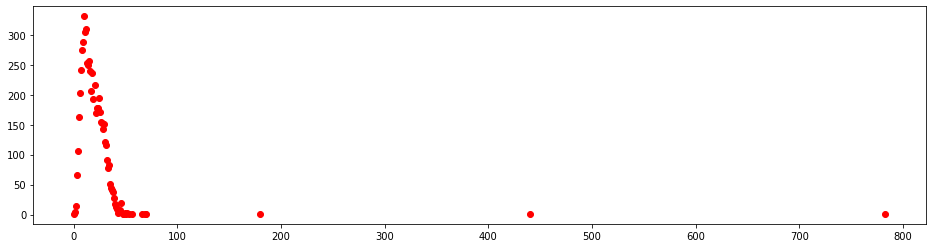

In [46]:
plt.figure(figsize=(16,4))
plt.plot(list(fd.keys()), list(fd.values()), 'ro')
#plt.xlim([0,100])
#plt.ylim([0,300])
plt.show()

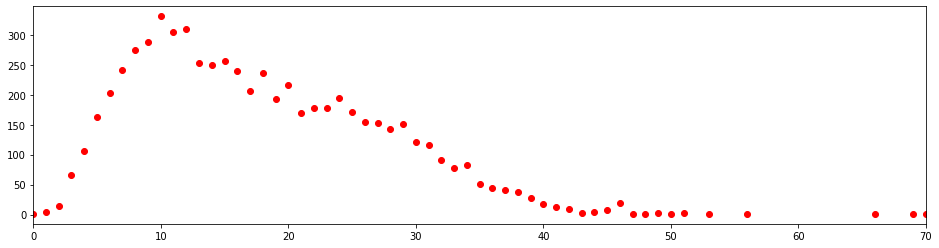

In [47]:
plt.figure(figsize=(16,4))
plt.plot(list(fd.keys()), list(fd.values()), 'ro')
plt.xlim([0,70])
#plt.ylim([0,300])
plt.show()

Из графиков видно, что частота твитов начиная от длинн более 4х, но менее 45 слов превышает 15 (что уже достаточно для батчей). Таким образом пэддинг не будет сильно влиять. В данной работе принимимае, что у нас будет один батч и максимальная динна предолжения 50 слов. Предложения, длиянной менее 50 слов  будем дозаполнятьнулевыми эмбединг-векторами (пэддинг) до 50ти. Для того, чтобы делать пэддинг используем функции pad_sequence (заполнение пэддинг) и pack_padded_sequence (для упаковки и одновременной подачи - ниже пример работы механизма). Судя из статей эти функции указывают lstm на пэддинги и она не учитывает их при тренировке.
Напишем класс для модели:

In [251]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.autograd import Variable

class Net(nn.Module):
    #lstm_units - количество lstm ячеек, то есть длина вектора на выходе lstm слоя
    #embeddings_dim - длинна эмбединга
    #описываем фнукцию класса Net, которая будет вызываться автоматичесики при создании экземпляра объекта класса
    def __init__(self, 
                 embedding_dim, 
                 lstm_units, 
                 batch_size, 
                 lstm_layers = 1, 
                 bidirectional = False, 
                 hidden_dim = 128,
                 dropout = 0):
        super(Net, self).__init__()
        #создаем переменную и инициализиуем слой lstm
        #batch_fist = True говорит о том, что мы будем использовать упаковку и заполнение нелувыми эмбеингами педложения с меньшим количество слов, чем мксимальное в батче
        self.lstm = nn.LSTM(embedding_dim, lstm_units, num_layers = lstm_layers, bidirectional = bidirectional ,batch_first=True)
        #создаем переменную и инициализируем линейный слой. 1 - значит длина вектора на выходе (float от 0 до 1)
        self.num_directions = 2 if bidirectional == True else 1
        self.sigm = nn.Sigmoid()
        #self.relu = nn.ReLU()
        self.fc = nn.Linear(lstm_units * self.num_directions, 1)
        #self.fc1 = nn.Linear(lstm_units * self.num_directions, hidden_dim)
        #self.fc2 = nn.Linear(hidden_dim, 1)
        #self.dropout = nn.Dropout(dropout)
        #self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.lstm_units = lstm_units
        self.bidirectional = bidirectional
        
    #фукнция инициализации h0, c0
    def init_hidden(self, batch_size):
        h, c = (Variable(torch.zeros(self.lstm_layers * self.num_directions, batch_size, self.lstm_units)),
                Variable(torch.zeros(self.lstm_layers * self.num_directions, batch_size, self.lstm_units)))
        return h, c
        
    def forward(self, tweets, text_length):
        batch_size = len(tweets)
        h_0, c_0 = self.init_hidden(batch_size)
        #добавляем нулевые эмбединги для твитов с меньшей длинной чем максимальное в батче
        padded = pad_sequence(tweets, batch_first=True)
        tweet_lengths = [len(i) for i in tweets] #список длин предложений
        #сортируем по убыванию и упаковываем твиты (что-то в жухе танспоирования). 
        #на выходе 2 тензора и второй описывает сколько твитов имеет ненулевые эмбединги на каждой определенной позиции
        packed_embedded = pack_padded_sequence(padded, tweet_lengths, batch_first=True, enforce_sorted=False) #по умолчанию сортируетпо убыванию длинны
        output, (shortterm, longterm) = self.lstm(packed_embedded, (h_0, c_0))
        #распаковываем обратно (pad нули будут присутствовать)
        output_unpacked, output_lengths = pad_packed_sequence(output, batch_first=True)
        out = output_unpacked[:, -1, :]
        #если дальше испольовем output, то back propogation не работает, то есть всегда один и тот же результат. а вот с состояними longterm все вычисляется
        if self.bidirectional:
            longterm = torch.cat((longterm[-2, :, :], longterm[-1, :, :]), dim=1)
        prediction = self.sigm(self.fc(longterm))
        #почему-то получаются отрицтальные значения и я не знаю что с ними делать
        #sig = self.relu(longterm)
        #dense1 = self.fc1(sig)
        #drop = self.dropout(dense1)
        #prediction = self.fc2(drop)
        return prediction

так как мы будем испоьлзовать максимальную длинну предложения, то отфильтруем (удалим) сильно длиынне предолжения, которые встречаются редко. определеяем по графику, что хвост с частотой встречаемости длинн больше 45 стремится к нулю. берем максимльную длинну 50 слов

In [49]:
max_len = 50
index_norm = [i for i, tweet in enumerate(X_w2v_lem_nostops) if (len(tweet) <= max_len) and (len(tweet) != 0)]

In [50]:
print( "количество удаленных твитов-выбросов: ", len ([i for i, tweet in enumerate(X_w2v_lem_nostops) if len(tweet) > max_len]))

количество удаленных твитов-выбросов:  11


In [51]:
X_norm = list(np.array(X_w2v_lem_nostops)[index_norm])
y_norm = list(np.array(labels)[index_norm])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42, stratify=y_norm)

In [53]:
X_train_t = [torch.tensor(emb_tweet) for emb_tweet in X_train]
X_test_t = [torch.tensor(emb_tweet) for emb_tweet in X_test]
y_train_t = torch.tensor(y_train).float()
y_test_t = torch.tensor(y_test).float()

In [54]:
len(X_train_t)

5126

In [55]:
#фукнция расчета точности предсказания accuracy
def accuracy(probs, target):
    correct = (probs > 0.5) == target
    accuracy = correct.sum().item() / len(target)
    return accuracy

Напишем код для тренировки и оценки модели bidirectional lstm:

In [254]:
net = Net(300, lstm_units = max_len, batch_size = len(X_train_t), lstm_layers = 1, bidirectional = True, hidden_dim=128, dropout = 0.5)

optimizer = optim.SGD(net.parameters(), lr=0.1)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

best_valid_loss = float('inf')

epochs = 200

for epoch in range(epochs):
    
    predictions = net.forward(X_train_t, max_len)
    optimizer.zero_grad()
    loss = criterion(predictions.reshape(-1), y_train_t)
    acc = accuracy(predictions.reshape(-1), y_train_t) 
    loss.backward()
    optimizer.step()
    print(loss)
    
    with torch.no_grad():
        predictions_valid = net(X_test_t, max_len).reshape(-1)
        loss_valid = criterion(predictions_valid, y_test_t)
        acc_valid = accuracy(predictions_valid, y_test_t)
    
    if loss_valid < best_valid_loss:
        best_valid_loss = loss_valid
        torch.save(net.state_dict(), 'saved_weights'+'.pt')
    if epoch%10 == 0: print('Epoch ', epoch)
    print(f'\tTrain Loss: {loss:.3f} | Train Acc: {acc * 100:.2f}%')
    print(f'\t Val. Loss: {loss_valid:.3f} |  Val. Acc: {acc_valid * 100:.2f}%')

tensor(0.7012, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch  0
	Train Loss: 0.701 | Train Acc: 49.86%
	 Val. Loss: 0.672 |  Val. Acc: 71.45%
tensor(0.6713, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.671 | Train Acc: 71.75%
	 Val. Loss: 0.651 |  Val. Acc: 72.70%
tensor(0.6497, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.650 | Train Acc: 75.97%
	 Val. Loss: 0.635 |  Val. Acc: 73.09%
tensor(0.6328, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.633 | Train Acc: 76.10%
	 Val. Loss: 0.621 |  Val. Acc: 73.24%
tensor(0.6187, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.619 | Train Acc: 76.28%
	 Val. Loss: 0.610 |  Val. Acc: 73.79%
tensor(0.6063, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.606 | Train Acc: 76.55%
	 Val. Loss: 0.599 |  Val. Acc: 74.02%
tensor(0.5950, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.595 | Train Acc: 76.65%
	 Val. Loss: 0.589 |  Val. Acc: 74.18%
tensor(0.5847, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 

	Train Loss: 0.385 | Train Acc: 82.97%
	 Val. Loss: 0.381 |  Val. Acc: 82.92%
tensor(0.3839, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.384 | Train Acc: 83.03%
	 Val. Loss: 0.379 |  Val. Acc: 82.84%
tensor(0.3824, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.382 | Train Acc: 83.07%
	 Val. Loss: 0.378 |  Val. Acc: 83.00%
tensor(0.3809, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.381 | Train Acc: 83.20%
	 Val. Loss: 0.376 |  Val. Acc: 83.15%
tensor(0.3795, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.379 | Train Acc: 83.22%
	 Val. Loss: 0.375 |  Val. Acc: 83.23%
tensor(0.3781, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.378 | Train Acc: 83.22%
	 Val. Loss: 0.373 |  Val. Acc: 83.31%
tensor(0.3767, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.377 | Train Acc: 83.24%
	 Val. Loss: 0.372 |  Val. Acc: 83.31%
tensor(0.3753, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.375 | Train Acc: 83.24%
	 Val. Loss: 0.370 |  Val. Acc: 83.31

tensor(0.3218, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.322 | Train Acc: 85.27%
	 Val. Loss: 0.317 |  Val. Acc: 86.19%
tensor(0.3211, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.321 | Train Acc: 85.31%
	 Val. Loss: 0.317 |  Val. Acc: 86.19%
tensor(0.3204, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.320 | Train Acc: 85.33%
	 Val. Loss: 0.316 |  Val. Acc: 86.19%
tensor(0.3197, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.320 | Train Acc: 85.39%
	 Val. Loss: 0.315 |  Val. Acc: 86.27%
tensor(0.3190, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.319 | Train Acc: 85.41%
	 Val. Loss: 0.315 |  Val. Acc: 86.27%
tensor(0.3183, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.318 | Train Acc: 85.45%
	 Val. Loss: 0.314 |  Val. Acc: 86.35%
tensor(0.3177, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.318 | Train Acc: 85.49%
	 Val. Loss: 0.314 |  Val. Acc: 86.35%
tensor(0.3170, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch  130
	Train Loss

	Train Loss: 0.281 | Train Acc: 87.87%
	 Val. Loss: 0.281 |  Val. Acc: 88.92%
tensor(0.2801, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.280 | Train Acc: 87.94%
	 Val. Loss: 0.281 |  Val. Acc: 88.92%
tensor(0.2794, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.279 | Train Acc: 88.00%
	 Val. Loss: 0.280 |  Val. Acc: 89.00%
tensor(0.2788, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.279 | Train Acc: 88.06%
	 Val. Loss: 0.279 |  Val. Acc: 89.08%
tensor(0.2781, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.278 | Train Acc: 88.10%
	 Val. Loss: 0.279 |  Val. Acc: 89.08%
tensor(0.2774, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.277 | Train Acc: 88.12%
	 Val. Loss: 0.278 |  Val. Acc: 89.24%
tensor(0.2768, grad_fn=<BinaryCrossEntropyBackward0>)
Epoch  190
	Train Loss: 0.277 | Train Acc: 88.16%
	 Val. Loss: 0.278 |  Val. Acc: 89.24%
tensor(0.2761, grad_fn=<BinaryCrossEntropyBackward0>)
	Train Loss: 0.276 | Train Acc: 88.20%
	 Val. Loss: 0.277 |  Val.

Вывод: на 200х эпохах сеть получаила точно 87,4%. судя по близким значениям train и validate можно еще тренировать и получить более высокие результаты. Важно отметить, что при использовании одностороннего lstm модель уперлась в потолок точности 72%.

In [438]:
#пример использования pad_sequence и пр
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
samp = [torch.tensor([[7,7],[8,8],[9,9]]), torch.tensor([[5,5], [6,6]]), torch.tensor([[1,1],[2,2],[3,3], [4,4]])]

#packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
ps = pad_sequence(samp, batch_first=True)
text_len = ps.size()

pps = pack_padded_sequence(ps, [3,2,4], batch_first=True, enforce_sorted=False)
pps

PackedSequence(data=tensor([[1, 1],
        [7, 7],
        [5, 5],
        [2, 2],
        [8, 8],
        [6, 6],
        [3, 3],
        [9, 9],
        [4, 4]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))

In [214]:
ps.size()

torch.Size([2, 3, 2])

In [217]:
ps

tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[5, 5],
         [6, 6],
         [0, 0]]])

In [235]:
output, _ = pad_packed_sequence(pps, batch_first=True, total_length=3)
pad_packed_sequence(pps, batch_first=True, total_length=3)

(tensor([[[1, 1],
          [2, 2],
          [3, 3]],
 
         [[5, 5],
          [6, 6],
          [0, 0]]]), tensor([3, 2]))

In [236]:
output

tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[5, 5],
         [6, 6],
         [0, 0]]])